Projet Réalisé Par:
            OUAAZZI Mohammed Taha
            NAJIH Houssam

Le paludisme est une maladie infectieuse grave transmise par les moustiques, affectant des millions de personnes chaque année, principalement dans les régions tropicales et subtropicales. Une détection précoce et précise est cruciale pour un traitement efficace et la réduction de la mortalité.

Le diagnostic du paludisme repose souvent sur l'examen microscopique des frottis sanguins, une procédure longue et nécessitant une expertise médicale spécialisée. Ce projet vise à automatiser et à accélérer ce processus grâce à l'IA.

1. Télécharger et Charger les Données:

Le code charge les images à partir des répertoires spécifiés, redimensionne les images à 64x64 pixels, et combine les données d'images parasitées et non infectées en un seul tableau.

In [2]:
import os
from glob import glob

parasitized_dir = 'C:/Users/RIDACHAFI/Desktop/FOAD/malaria_hematie_dataset/malaria_hematie_dataset/parasitized'
uninfected_dir = 'C:/Users/RIDACHAFI/Desktop/FOAD/malaria_hematie_dataset/malaria_hematie_dataset/uninfected'

parasitized_files = glob(os.path.join(parasitized_dir, '*.png'))
uninfected_files = glob(os.path.join(uninfected_dir, '*.png'))

print(f"Nombre d'images parasitées : {len(parasitized_files)}")
print(f"Nombre d'images non infectées : {len(uninfected_files)}")

Nombre d'images parasitées : 13779
Nombre d'images non infectées : 13779


In [3]:
from PIL import Image
import numpy as np
import pandas as pd

def load_images(file_paths, label):
    images = []
    labels = []
    for file in file_paths:
        img = Image.open(file).resize((64, 64))
        img = np.array(img)
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

parasitized_images, parasitized_labels = load_images(parasitized_files, 1)
uninfected_images, uninfected_labels = load_images(uninfected_files, 0)

images = np.concatenate((parasitized_images, uninfected_images), axis=0)
labels = np.concatenate((parasitized_labels, uninfected_labels), axis=0)

print(f"Shape des images: {images.shape}")
print(f"Shape des labels: {labels.shape}")


Shape des images: (27558, 64, 64, 3)
Shape des labels: (27558,)


2. Normaliser les Images:

Normalisez les images pour que les valeurs des pixels soient comprises entre 0 et 1 en les divisant par 255.

La normalisation des images permet de standardiser les valeurs des pixels, facilitant ainsi l'entraînement du modèle.

In [4]:
images = images / 255.0

3. Encoder les Labels:

Utilisez LabelEncoder de sklearn pour transformer les labels catégoriels en valeurs numériques.

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)

4. Faire de la Data Augmentation:

Utilisez ImageDataGenerator de Keras pour augmenter les données en appliquant des transformations comme des rotations, des zooms, des flips, etc.

La data augmentation génère des variations des images d'entraînement, aidant ainsi le modèle à généraliser mieux et à éviter le surapprentissage.

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(images)

5. Afficher les Images Augmentées:

Affichez quelques exemples d'images augmentées pour visualiser les transformations appliquées.

L'affichage des images augmentées permet de vérifier visuellement les transformations et de s'assurer qu'elles sont appliquées correctement.

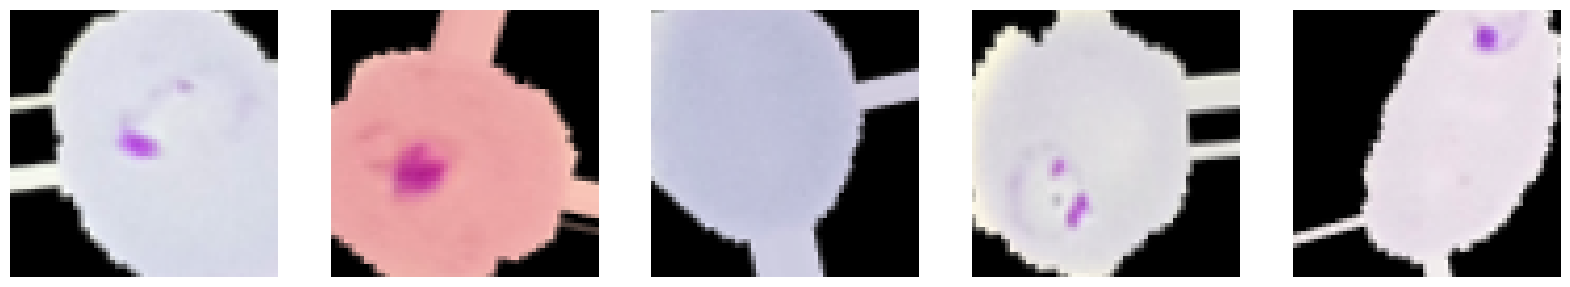

In [9]:
import matplotlib.pyplot as plt

def plot_augmented_images(datagen, images, labels, class_names, num_imgs=5):
    fig, axes = plt.subplots(1, num_imgs, figsize=(20, 20))
    for img, ax in zip(images[:num_imgs], axes):
        augmented_img = next(datagen.flow(np.expand_dims(img, axis=0), batch_size=1))[0]
        ax.imshow(augmented_img)
        ax.axis('off')
    plt.show()

class_names = ['Uninfected', 'Parasitized']
plot_augmented_images(datagen, images, labels, class_names)


II) Entraînement de 3 Modèles

1) Implémentation de 2 Callbacks

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)


2. Implémentation de 3 CNN pour la Labelisation à l'aide de Keras

Modèle from scratch avec Sequential :

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model_scratch = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_scratch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Fine-tuning du VGG16 pré-entraîné sur ImageNet :

In [14]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model_vgg.layers:
    layer.trainable = False

x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions)
model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


Fine-tuning du ResNet50 pré-entraîné sur ImageNet :

In [15]:
from keras.applications import ResNet50

base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model_resnet.layers:
    layer.trainable = False

x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step


3. Entraînement des 3 modèles à l'aide des Callbacks implémentés

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

history_scratch = model_scratch.fit(datagen.flow(X_train, y_train, batch_size=32),
                                    validation_data=(X_val, y_val),
                                    epochs=5, callbacks=[early_stopping, lr_reduction])

history_vgg = model_vgg.fit(datagen.flow(X_train, y_train, batch_size=32),
                            validation_data=(X_val, y_val),
                            epochs=5, callbacks=[early_stopping, lr_reduction])

history_resnet = model_resnet.fit(datagen.flow(X_train, y_train, batch_size=32),
                                  validation_data=(X_val, y_val),
                                  epochs=5, callbacks=[early_stopping, lr_reduction])


Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 286s 412ms/step - accuracy: 0.9246 - loss: 0.2166 - val_accuracy: 0.9552 - val_loss: 0.1462 - learning_rate: 0.0010
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 289s 418ms/step - accuracy: 0.9279 - loss: 0.2123 - val_accuracy: 0.9585 - val_loss: 0.1333 - learning_rate: 0.0010
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 282s 408ms/step - accuracy: 0.9263 - loss: 0.2080 - val_accuracy: 0.9572 - val_loss: 0.1399 - learning_rate: 0.0010
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 292s 424ms/step - accuracy: 0.9299 - loss: 0.2020 - val_accuracy: 0.9603 - val_loss: 0.1306 - learning_rate: 0.0010
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 296s 429ms/step - accuracy: 0.9352 - loss: 0.1902 - val_accuracy: 0.9574 - val_loss: 0.1264 - learning_rate: 0.0010
Epoch 1/5
  8/689 ━━━━━━━━━━━━━━━━━━━━ 40:32 4s/step - accuracy: 0.4922 - loss: 0.7198

KeyboardInterrupt: 

4. Sauvegarder les poids des 3 différents modèles

In [21]:
model_scratch.save_weights('model_scratch.weights.h5')
model_vgg.save_weights('model_vgg.weights.h5')
model_resnet.save_weights('model_resnet.weights.h5')

III) Test des Modèles

1. Calculer la Matrice de Confusion

173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 468s 3s/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 106s 592ms/step


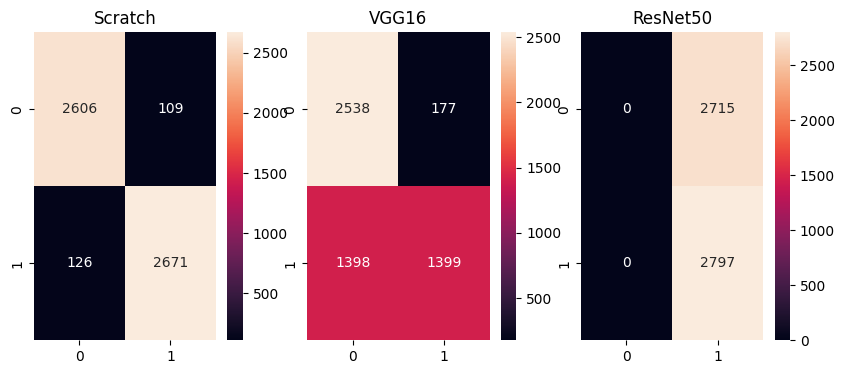

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_scratch = (model_scratch.predict(X_val) > 0.5).astype("int32")
y_pred_vgg = (model_vgg.predict(X_val) > 0.5).astype("int32")
y_pred_resnet = (model_resnet.predict(X_val) > 0.5).astype("int32")

cm_scratch = confusion_matrix(y_val, y_pred_scratch)
cm_vgg = confusion_matrix(y_val, y_pred_vgg)
cm_resnet = confusion_matrix(y_val, y_pred_resnet)

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
sns.heatmap(cm_scratch, annot=True, fmt="d")
plt.title("Scratch")

plt.subplot(1, 3, 2)
sns.heatmap(cm_vgg, annot=True, fmt="d")
plt.title("VGG16")

plt.subplot(1, 3, 3)
sns.heatmap(cm_resnet, annot=True, fmt="d")
plt.title("ResNet50")

plt.show()


2. Calculer les métriques de performance

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

print("Metrics for Scratch Model:")
print_metrics(y_val, y_pred_scratch)
print("\nMetrics for VGG16 Model:")
print_metrics(y_val, y_pred_vgg)
print("\nMetrics for ResNet50 Model:")
print_metrics(y_val, y_pred_resnet)

Metrics for Scratch Model:
Accuracy: 0.9574
Precision: 0.9608
Recall: 0.9550
F1 Score: 0.9579

Metrics for VGG16 Model:
Accuracy: 0.7143
Precision: 0.8877
Recall: 0.5002
F1 Score: 0.6398

Metrics for ResNet50 Model:
Accuracy: 0.5074
Precision: 0.5074
Recall: 1.0000
F1 Score: 0.6732


3. Afficher le graphique ROC et calculer l’AUC de chacun des 3 modèles

173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 100s 576ms/step


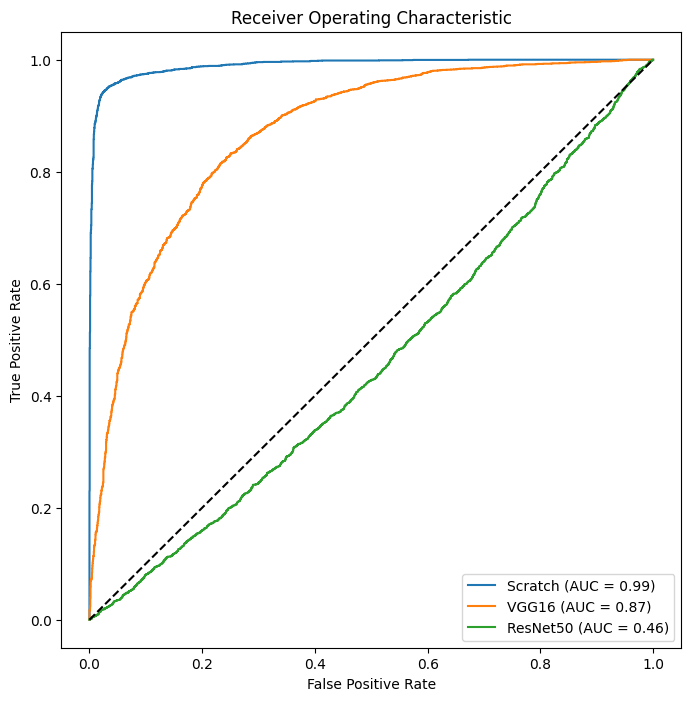

In [25]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(8, 8))
plot_roc(y_val, model_scratch.predict(X_val), "Scratch")
plot_roc(y_val, model_vgg.predict(X_val), "VGG16")
plot_roc(y_val, model_resnet.predict(X_val), "ResNet50")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
